# Next Activity Prediction Model Training

This notebook demonstrates how to train an LSTM model for next activity prediction.

The model:
- Filters event logs to only "start" and "complete" lifecycle transitions
- Learns to predict the next activity in a case
- Detects when a case should end (END token prediction)


## 1. Setup and Imports


In [1]:
import sys
from pathlib import Path
import logging

# Add project root to Python path
project_root = Path.cwd().parent if Path.cwd().name == 'next_activity_prediction' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

from next_activity_prediction import NextActivityConfig, train_model


d:\Repos\process-simulation-engine-1\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 2. Configuration

Configure the model architecture and training parameters.


In [2]:
# Path to your event log
EVENT_LOG_PATH = r"..\eventlog\eventlog.xes.gz"  # Update this to your event log path

# Model configuration
config = NextActivityConfig(
    # Model architecture
    sequence_length=50,      # Maximum sequence length for padding/truncation
    embedding_dim=128,       # Embedding dimension for activity tokens
    lstm_units=256,          # Number of LSTM units per layer
    lstm_layers=2,           # Number of stacked LSTM layers
    dropout_rate=0.1,        # Dropout rate for regularization
    
    # Training parameters
    batch_size=64,           # Batch size for training
    learning_rate=0.001,     # Initial learning rate
    epochs=50,               # Maximum number of training epochs
    validation_split=0.1,    # Fraction of data for validation
    early_stopping_patience=10,  # Early stopping patience
    
    # Paths
    model_dir="models/next_activity_lstm",  # Where to save the model
    event_log_path=EVENT_LOG_PATH,
    
    # Data preprocessing
    min_case_length=2,       # Minimum case length to include
    max_case_length=200,     # Maximum case length (longer cases are truncated)
    
    # Class weighting (to better fit END token distribution)
    use_class_weights=True,  # Enable class weighting for imbalanced classes
    class_weight_method="balanced",  # "balanced" (sklearn style), "inverse_freq", or "custom"
    end_token_weight=None,   # Manual weight for END token (None = auto-calculate based on method)
    
    # Position-based sample weighting (optional - emphasizes later positions more likely to be END)
    use_position_weights=False,  # Set to True to enable position-based weighting
    position_weight_power=1.5,   # Power for position weighting (higher = more emphasis on later positions)
)

print(f"Configuration:")
print(f"  Event log: {config.event_log_path}")
print(f"  Model directory: {config.model_dir}")
print(f"  Sequence length: {config.sequence_length}")
print(f"  LSTM units: {config.lstm_units}")
print(f"  LSTM layers: {config.lstm_layers}")
print(f"  Batch size: {config.batch_size}")
print(f"  Epochs: {config.epochs}")
print(f"\nClass weighting:")
print(f"  Enabled: {config.use_class_weights}")
print(f"  Method: {config.class_weight_method}")
print(f"  END token weight: {config.end_token_weight if config.end_token_weight else 'auto'}")
print(f"  Position weights: {config.use_position_weights} (power={config.position_weight_power})")


Configuration:
  Event log: ..\eventlog\eventlog.xes.gz
  Model directory: models\next_activity_lstm
  Sequence length: 50
  LSTM units: 256
  LSTM layers: 2
  Batch size: 64
  Epochs: 50

Class weighting:
  Enabled: True
  Method: balanced
  END token weight: auto
  Position weights: False (power=1.5)


## 3. Verify Event Log

Check that the event log exists and has the required columns.


In [3]:
import pandas as pd
import pm4py

# Load and inspect event log
if Path(EVENT_LOG_PATH).exists():
    log = pm4py.read_xes(EVENT_LOG_PATH)
    df = pm4py.convert_to_dataframe(log)
    
    print(f"Event log loaded: {len(df)} events, {df['case:concept:name'].nunique()} cases")
    print(f"\nColumns: {list(df.columns)}")
    
    # Check for lifecycle column
    if 'lifecycle:transition' in df.columns:
        lifecycle_counts = df['lifecycle:transition'].value_counts()
        print(f"\nLifecycle transitions:")
        print(lifecycle_counts)
        
        start_complete = df[df['lifecycle:transition'].isin(['start', 'complete'])]
        print(f"\nStart/Complete events: {len(start_complete)} ({len(start_complete)/len(df):.1%})")
    else:
        print("\nWarning: No 'lifecycle:transition' column found")
    
    # Show sample activities
    if 'concept:name' in df.columns:
        activities = df['concept:name'].unique()
        print(f"\nUnique activities: {len(activities)}")
        print(f"Sample activities: {list(activities[:10])}")
else:
    print(f"Event log not found: {EVENT_LOG_PATH}")
    print("Please update EVENT_LOG_PATH in the configuration cell above.")


d:\Repos\process-simulation-engine-1\.venv\Lib\site-packages\pm4py\utils.py:987: UserWarning: In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.
  warnings.warn("In the current version, the import/export operation uses `rustxes` by default for importing/exporting files faster. Please uninstall `rustxes` to revert the behavior.")


Event log loaded: 1202267 events, 31509 cases

Columns: ['MonthlyCost', 'Accepted', 'case:LoanGoal', 'time:timestamp', 'case:ApplicationType', 'OfferedAmount', 'OfferID', 'concept:name', 'org:resource', 'Action', 'lifecycle:transition', 'CreditScore', 'FirstWithdrawalAmount', 'case:concept:name', 'NumberOfTerms', 'Selected', 'EventOrigin', 'case:RequestedAmount', 'EventID']

Lifecycle transitions:
lifecycle:transition
complete     475306
suspend      215402
schedule     149104
start        128227
resume       127160
ate_abort     85224
withdraw      21844
Name: count, dtype: int64

Start/Complete events: 603533 (50.2%)

Unique activities: 26
Sample activities: ['A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Complete application', 'A_Concept', 'A_Accepted', 'O_Create Offer', 'O_Created', 'O_Sent (mail and online)', 'W_Call after offers']


## 4. Train the Model

Train the LSTM model on the event log. This will:
1. Load and preprocess the event log
2. Filter to start/complete lifecycles
3. Extract activity sequences
4. Create training/validation splits
5. Train the model with early stopping
6. Save the trained model and metadata


In [4]:
# Train the model
history = train_model(config)

print("\nTraining completed!")


2026-01-09 01:24:51,802 - next_activity_prediction.trainer - INFO - Starting model training...
2026-01-09 01:24:51,803 - next_activity_prediction.trainer - INFO - Event log: ..\eventlog\eventlog.xes.gz
2026-01-09 01:24:51,803 - next_activity_prediction.trainer - INFO - Model directory: models\next_activity_lstm
2026-01-09 01:24:51,804 - next_activity_prediction.data_preprocessing - INFO - Loading event log from ..\eventlog\eventlog.xes.gz
2026-01-09 01:24:58,713 - next_activity_prediction.data_preprocessing - INFO - Loaded 1202267 events, 31509 cases
2026-01-09 01:24:58,849 - next_activity_prediction.data_preprocessing - INFO - Filtered to start/complete lifecycles: 1,202,267 -> 603,533 (50.2%)
2026-01-09 01:25:00,012 - next_activity_prediction.data_preprocessing - INFO - Extracted 31509 case sequences
2026-01-09 01:25:00,016 - next_activity_prediction.data_preprocessing - INFO - Average sequence length: 20.2 (including END)
2026-01-09 01:25:00,020 - next_activity_prediction.data_prepr

Model: "next_activity_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity_embedding  │ (None, 50, 128)   │      3,584 │ sequence_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ sequence_input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50, 256)   │    394,240 │ activity_embeddi… │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ lstm_1[0][0],     │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_dropout       │ (None, 256)       │          0 │ lstm_2[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity_prediction │ (None, 28)        │      7,196 │ final_dropout[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 930,332 (3.55 MB)

 Trainable params: 930,332 (3.55 MB)

 Non-trainable params: 0 (0.00 B)

2026-01-09 01:25:02,794 - next_activity_prediction.utils - INFO - Class weights (method=balanced):
2026-01-09 01:25:02,795 - next_activity_prediction.utils - INFO -   END token (idx=27): count=28411, weight=0.735
2026-01-09 01:25:02,795 - next_activity_prediction.utils - INFO -   Min weight: 0.419, Max weight: 6963.833
2026-01-09 01:25:02,795 - next_activity_prediction.utils - INFO -   Average weight: 262.591


Epoch 1/50
8488/8488 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 1.5936 - sparse_categorical_accuracy: 0.6747
Epoch 1: val_loss improved from None to 0.54932, saving model to models\next_activity_lstm\checkpoints\best_model.keras

Epoch 1: finished saving model to models\next_activity_lstm\checkpoints\best_model.keras
8488/8488 ━━━━━━━━━━━━━━━━━━━━ 1409s 166ms/step - loss: 1.0907 - sparse_categorical_accuracy: 0.7356 - val_loss: 0.5493 - val_sparse_categorical_accuracy: 0.7964 - learning_rate: 0.0010
Epoch 2/50
8488/8488 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.8685 - sparse_categorical_accuracy: 0.7628
Epoch 2: val_loss did not improve from 0.54932
8488/8488 ━━━━━━━━━━━━━━━━━━━━ 1244s 147ms/step - loss: 0.8878 - sparse_categorical_accuracy: 0.7671 - val_loss: 0.5499 - val_sparse_categorical_accuracy: 0.7750 - learning_rate: 0.0010
Epoch 3/50
8488/8488 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.7677
Epoch 3: val_loss improved from 0.54932 to 0

2026-01-09 10:37:24,996 - next_activity_prediction.trainer - INFO - Saved final model to models\next_activity_lstm\model.keras
2026-01-09 10:37:24,997 - next_activity_prediction.trainer - INFO - Saved metadata to models\next_activity_lstm\metadata.json
2026-01-09 10:37:24,998 - next_activity_prediction.trainer - INFO - Training completed!
2026-01-09 10:37:24,998 - next_activity_prediction.trainer - INFO - Final train loss: 0.5566, val loss: 0.4979
2026-01-09 10:37:24,999 - next_activity_prediction.trainer - INFO - Final train accuracy: 0.7822, val accuracy: 0.8005



Training completed!


## 5. Training Results

Visualize training progress and metrics.


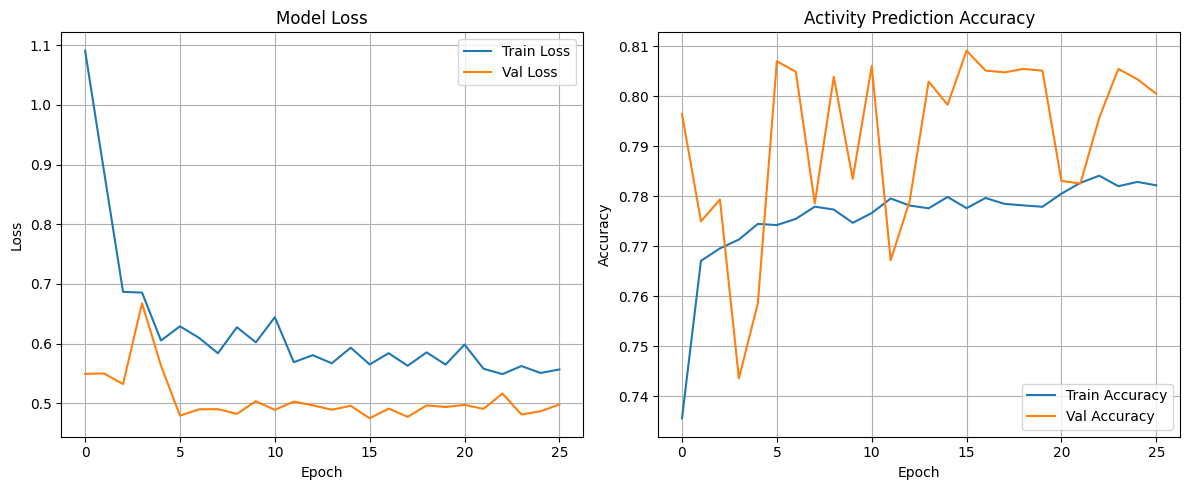

Final Training Metrics:
  Loss: 0.5566
  Accuracy: 0.7822

Final Validation Metrics:
  Loss: 0.4979
  Accuracy: 0.8005


In [5]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss
axes[0].plot(history['loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['sparse_categorical_accuracy'], label='Train Accuracy')
axes[1].plot(history['val_sparse_categorical_accuracy'], label='Val Accuracy')
axes[1].set_title('Activity Prediction Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print("Final Training Metrics:")
print(f"  Loss: {history['loss'][-1]:.4f}")
print(f"  Accuracy: {history['sparse_categorical_accuracy'][-1]:.4f}")
print(f"\nFinal Validation Metrics:")
print(f"  Loss: {history['val_loss'][-1]:.4f}")
print(f"  Accuracy: {history['val_sparse_categorical_accuracy'][-1]:.4f}")


## 6. Verify Model Files

Check that the model and metadata were saved correctly.


In [6]:
model_dir = Path(config.model_dir)

print(f"Model directory: {model_dir}")
print(f"\nFiles in model directory:")
if model_dir.exists():
    for file in sorted(model_dir.rglob('*')):
        if file.is_file():
            size = file.stat().st_size / (1024 * 1024)  # Size in MB
            print(f"  {file.relative_to(model_dir)} ({size:.2f} MB)")
    
    # Load and display metadata
    metadata_file = model_dir / "metadata.json"
    if metadata_file.exists():
        import json
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        print(f"\nModel Metadata:")
        print(f"  Vocabulary size: {metadata.get('vocab_size', 'N/A')}")
        print(f"  Sequence length: {metadata.get('sequence_length', 'N/A')}")
        print(f"  Embedding dim: {metadata.get('embedding_dim', 'N/A')}")
        print(f"  LSTM units: {metadata.get('lstm_units', 'N/A')}")
        print(f"  LSTM layers: {metadata.get('lstm_layers', 'N/A')}")
        print(f"  END token index: {metadata.get('end_token_idx', 'N/A')}")
        
        vocab_size = metadata.get('vocab_size', 0)
        print(f"\nVocabulary (first 20 activities):")
        idx_to_activity = metadata.get('idx_to_activity', {})
        for idx in sorted([int(k) for k in idx_to_activity.keys()])[:20]:
            if idx != 0:  # Skip PAD token
                print(f"  {idx}: {idx_to_activity[str(idx)]}")
else:
    print("Model directory does not exist.")


Model directory: models\next_activity_lstm

Files in model directory:
  checkpoints\best_model.keras (10.69 MB)
  metadata.json (0.00 MB)
  model.keras (10.69 MB)

Model Metadata:
  Vocabulary size: 28
  Sequence length: 50
  Embedding dim: 128
  LSTM units: 256
  LSTM layers: 2
  END token index: 27

Vocabulary (first 20 activities):
  1: A_Accepted
  2: A_Cancelled
  3: A_Complete
  4: A_Concept
  5: A_Create Application
  6: A_Denied
  7: A_Incomplete
  8: A_Pending
  9: A_Submitted
  10: A_Validating
  11: O_Accepted
  12: O_Cancelled
  13: O_Create Offer
  14: O_Created
  15: O_Refused
  16: O_Returned
  17: O_Sent (mail and online)
  18: O_Sent (online only)
  19: W_Assess potential fraud


## 7. Test the Predictor

Load the trained model and test it with a sample case.


In [7]:
from next_activity_prediction import LSTMNextActivityPredictor
from simulation.case_manager import CaseState

# Load the predictor
predictor = LSTMNextActivityPredictor(
    model_path=str(config.model_dir),
    end_threshold=config.end_threshold
)

print("Predictor loaded successfully!")
print(f"Vocabulary size: {len(predictor.activity_to_idx)} (including END)")
print(f"Sequence length: {predictor.sequence_length}")
print(f"END token index: {predictor.end_token_idx}")

# Create a test case
test_case = CaseState(
    case_id="test_case_1",
    case_type="Home improvement",
    application_type="New credit",
    requested_amount=10000.0
)

# Simulate a case progression
test_activities = [
    "A_Create Application",
    "A_Submitted",
    "W_Complete application"
]

print("\nTesting predictions:")
for i, activity in enumerate(test_activities):
    test_case.activity_history = test_activities[:i+1]
    next_activity, is_end = predictor.predict(test_case)
    
    print(f"\nStep {i+1}:")
    print(f"  History: {test_case.activity_history}")
    print(f"  Predicted next: {next_activity}")
    print(f"  Is END: {is_end}")
    
    if is_end:
        print("  Case ended!")
        break


AttributeError: 'NextActivityConfig' object has no attribute 'end_threshold'

## 8. Next Steps

The trained model is now ready to use in simulation:

1. **Automatic Integration**: The simulation engine will automatically load this model if it exists at `models/next_activity_lstm/`

2. **Manual Usage**: You can also explicitly create a predictor:
   ```python
   from next_activity_prediction import LSTMNextActivityPredictor
   predictor = LSTMNextActivityPredictor(model_path="models/next_activity_lstm")
   ```

3. **Run Simulation**: Use the predictor in your simulation runs - it will automatically be used by the DESEngine if available.

4. **Tune Parameters**: Adjust the configuration (sequence_length, lstm_units, etc.) and retrain if needed for better performance.
